<a href="https://colab.research.google.com/github/AIJuand/AI/blob/main/Dask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero hagamos algunas funciones de juguete, incy addque duerman un rato para simular el trabajo. Luego, programaremos la ejecución de estas funciones con normalidad.

En la siguiente parte, paralelizaremos este código.

In [ ]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [ ]:
%%time

x = inc(1)
y = inc(2)
z = add(x, y)
#Esto tarda tres segundos en ejecutarse porque llamamos a cada función secuencialmente

CPU times: user 18.4 ms, sys: 2.42 ms, total: 20.8 ms
Wall time: 3.01 s


Paralelizar con el dask.delayed
Esas dos llamadas de incremento podrían llamarse en paralelo, porque son totalmente independientes entre sí.

In [ ]:
from dask import delayed
#Para mantener las funciones originales para comparar, llamar directamente

In [ ]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 490 µs, sys: 85 µs, total: 575 µs
Wall time: 587 µs


**Esto se ejecutó de inmediato, ya que todavía no ha sucedido nada.**
El zobjeto es un objeto perezoso Delayed. Este objeto contiene todo lo que necesitamos para calcular el resultado final, incluidas las referencias a todas las funciones que se requieren y sus entradas y relaciones entre sí.

In [ ]:
z

Delayed('add-1984f008-738a-4b42-a899-4f556d9da486')

Podemos visualizar el gráfico de tareas para este valor con .visualize():

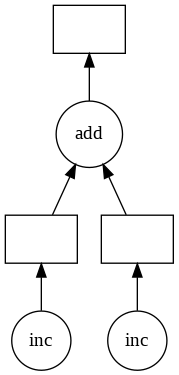

In [ ]:
z.visualize()

Para obtener el resultado, llame al compute. Tenga en cuenta que esto se ejecuta más rápido que el código original.

In [ ]:
%%time

z.compute()

CPU times: user 23.7 ms, sys: 2.72 ms, total: 26.4 ms
Wall time: 2.01 s


5

#Paralelizar un forbucle

In [ ]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
%%time

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 65.2 ms, sys: 6.03 ms, total: 71.3 ms
Wall time: 8.01 s


In [ ]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

total.compute()

CPU times: user 30.2 ms, sys: 5.4 ms, total: 35.6 ms
Wall time: 4.01 s


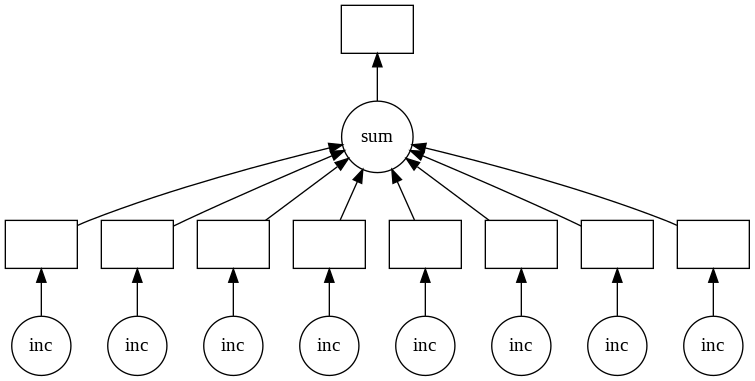

In [ ]:
total.visualize()

#El problema
Al solicitar un préstamo, como una tarjeta de crédito, una hipoteca, un préstamo para automóvil, etc., queremos estimar la probabilidad de incumplimiento y la ganancia (o pérdida) que se obtendrá. Esos modelos están compuestos por un conjunto complejo de ecuaciones que dependen unas de otras. Puede haber cientos de ecuaciones, cada una de las cuales podría tener hasta 20 entradas y producir 20 salidas. ¡Esa es una gran cantidad de información para realizar un seguimiento! Queremos evitar el seguimiento manual de las dependencias, así como el código desordenado como la siguiente función de Python:

In [ ]:
def final_equation(inputs):
    out1 = equation1(inputs)
    out2_1, out2_2, out2_3 = equation2(inputs, out1)
    out3_1, out3_2 = equation3(out2_3, out1)
    ...
    out_final = equation_n(inputs, out,...)
    return out_final
    #Esto se reduce a un problema de dependencia y orden conocido como programación de tareas.

Un gráfico acíclico dirigido (DAG) se usa comúnmente para resolver problemas de programación de tareas. Dask es una biblioteca para el cálculo de tareas retrasadas que utiliza gráficos dirigidos en su núcleo. dask.delayed es un decorador simple que convierte una función de Python en un vértice de gráfico. Si paso la salida de una función retrasada como parámetro a otra función retrasada, Dask crea un borde dirigido entre ellas. Veamos un ejemplo:

In [ ]:
def add(x, y):
    return x + y

add(2, 2)


4

Aquí tenemos una función para sumar dos números. Veamos qué sucede cuando lo envolvemos con dask.delayed:

In [ ]:
add = dask.delayed(add)
left = add(1, 1)
left
delayed('add-f6204fac-b067-40aa-9d6a-639fc719c3ce')

Delayed('str-f138527b-97b1-4478-b8a0-d269f57d05ed')

Podemos pasar esto como un argumento a nuestra dask.delayedfunción para comenzar a construir una cadena de cálculo

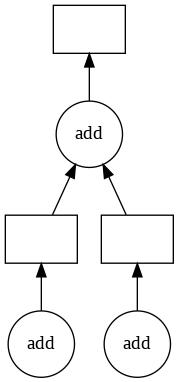

In [ ]:
right = add(1, 1)
four = add(left, right)
four.compute()
four.visualize()

#Ejemplo de crédito simulado
Supongamos que soy un banco hipotecario y tengo 10 personas solicitando una hipoteca. Quiero estimar la probabilidad promedio de incumplimiento del grupo en función de los años de historial crediticio e ingresos.

In [ ]:
hist_yrs = range(10)
incomes = range(10)

Supongamos también que el valor predeterminado es una función del historial de años incrementado y la mitad de los años de experiencia. Si bien esto podría escribirse como:

In [ ]:
def default(hist, income):
    return (hist + 1) ** 2 + (income / 2)

Sé que en el futuro necesitaré el historial incrementado para otro cálculo y quiero poder reutilizar el código y evitar hacer el cálculo dos veces. En cambio, puedo dividir esas funciones:

In [ ]:
from dask import delayed

@delayed
def increment(x):
    return x + 1

@delayed
def halve(y):
    return y / 2

@delayed
def default(hist, income):
    return hist**2 + income

Tenga en cuenta cómo envolví las funciones con delayed. Ahora, en lugar de devolver un número, estas funciones devolverán un Delayedobjeto. Aún mejor es que estas funciones también pueden tomar Delayedobjetos como entradas. Es este paso de Delayedobjetos como entradas a otras delayedfunciones lo que permite a Dask construir el gráfico de tareas. Ahora puedo llamar a estas funciones en mis datos al estilo del código Python normal:

In [ ]:
inc_hist = [increment(n) for n in hist_yrs]

In [ ]:
halved_income = [halve(n) for n in incomes]

In [ ]:
estimated_default = [default(hist, income) for hist, income in zip(inc_hist, halved_income)]

In [ ]:
@delayed
def agg(x, y):
    return x + y

def merge(seq):
    if len(seq) < 2:
        return seq
    middle = len(seq)//2
    left = merge(seq[:middle])
    right = merge(seq[middle:])
    if not right:
        return left
    return [agg(left[0], right[0])]

default_sum = merge(estimated_default)

In [ ]:
avg_default = default_sum[0] / 10
avg_default.compute()  # 40.75

40.75

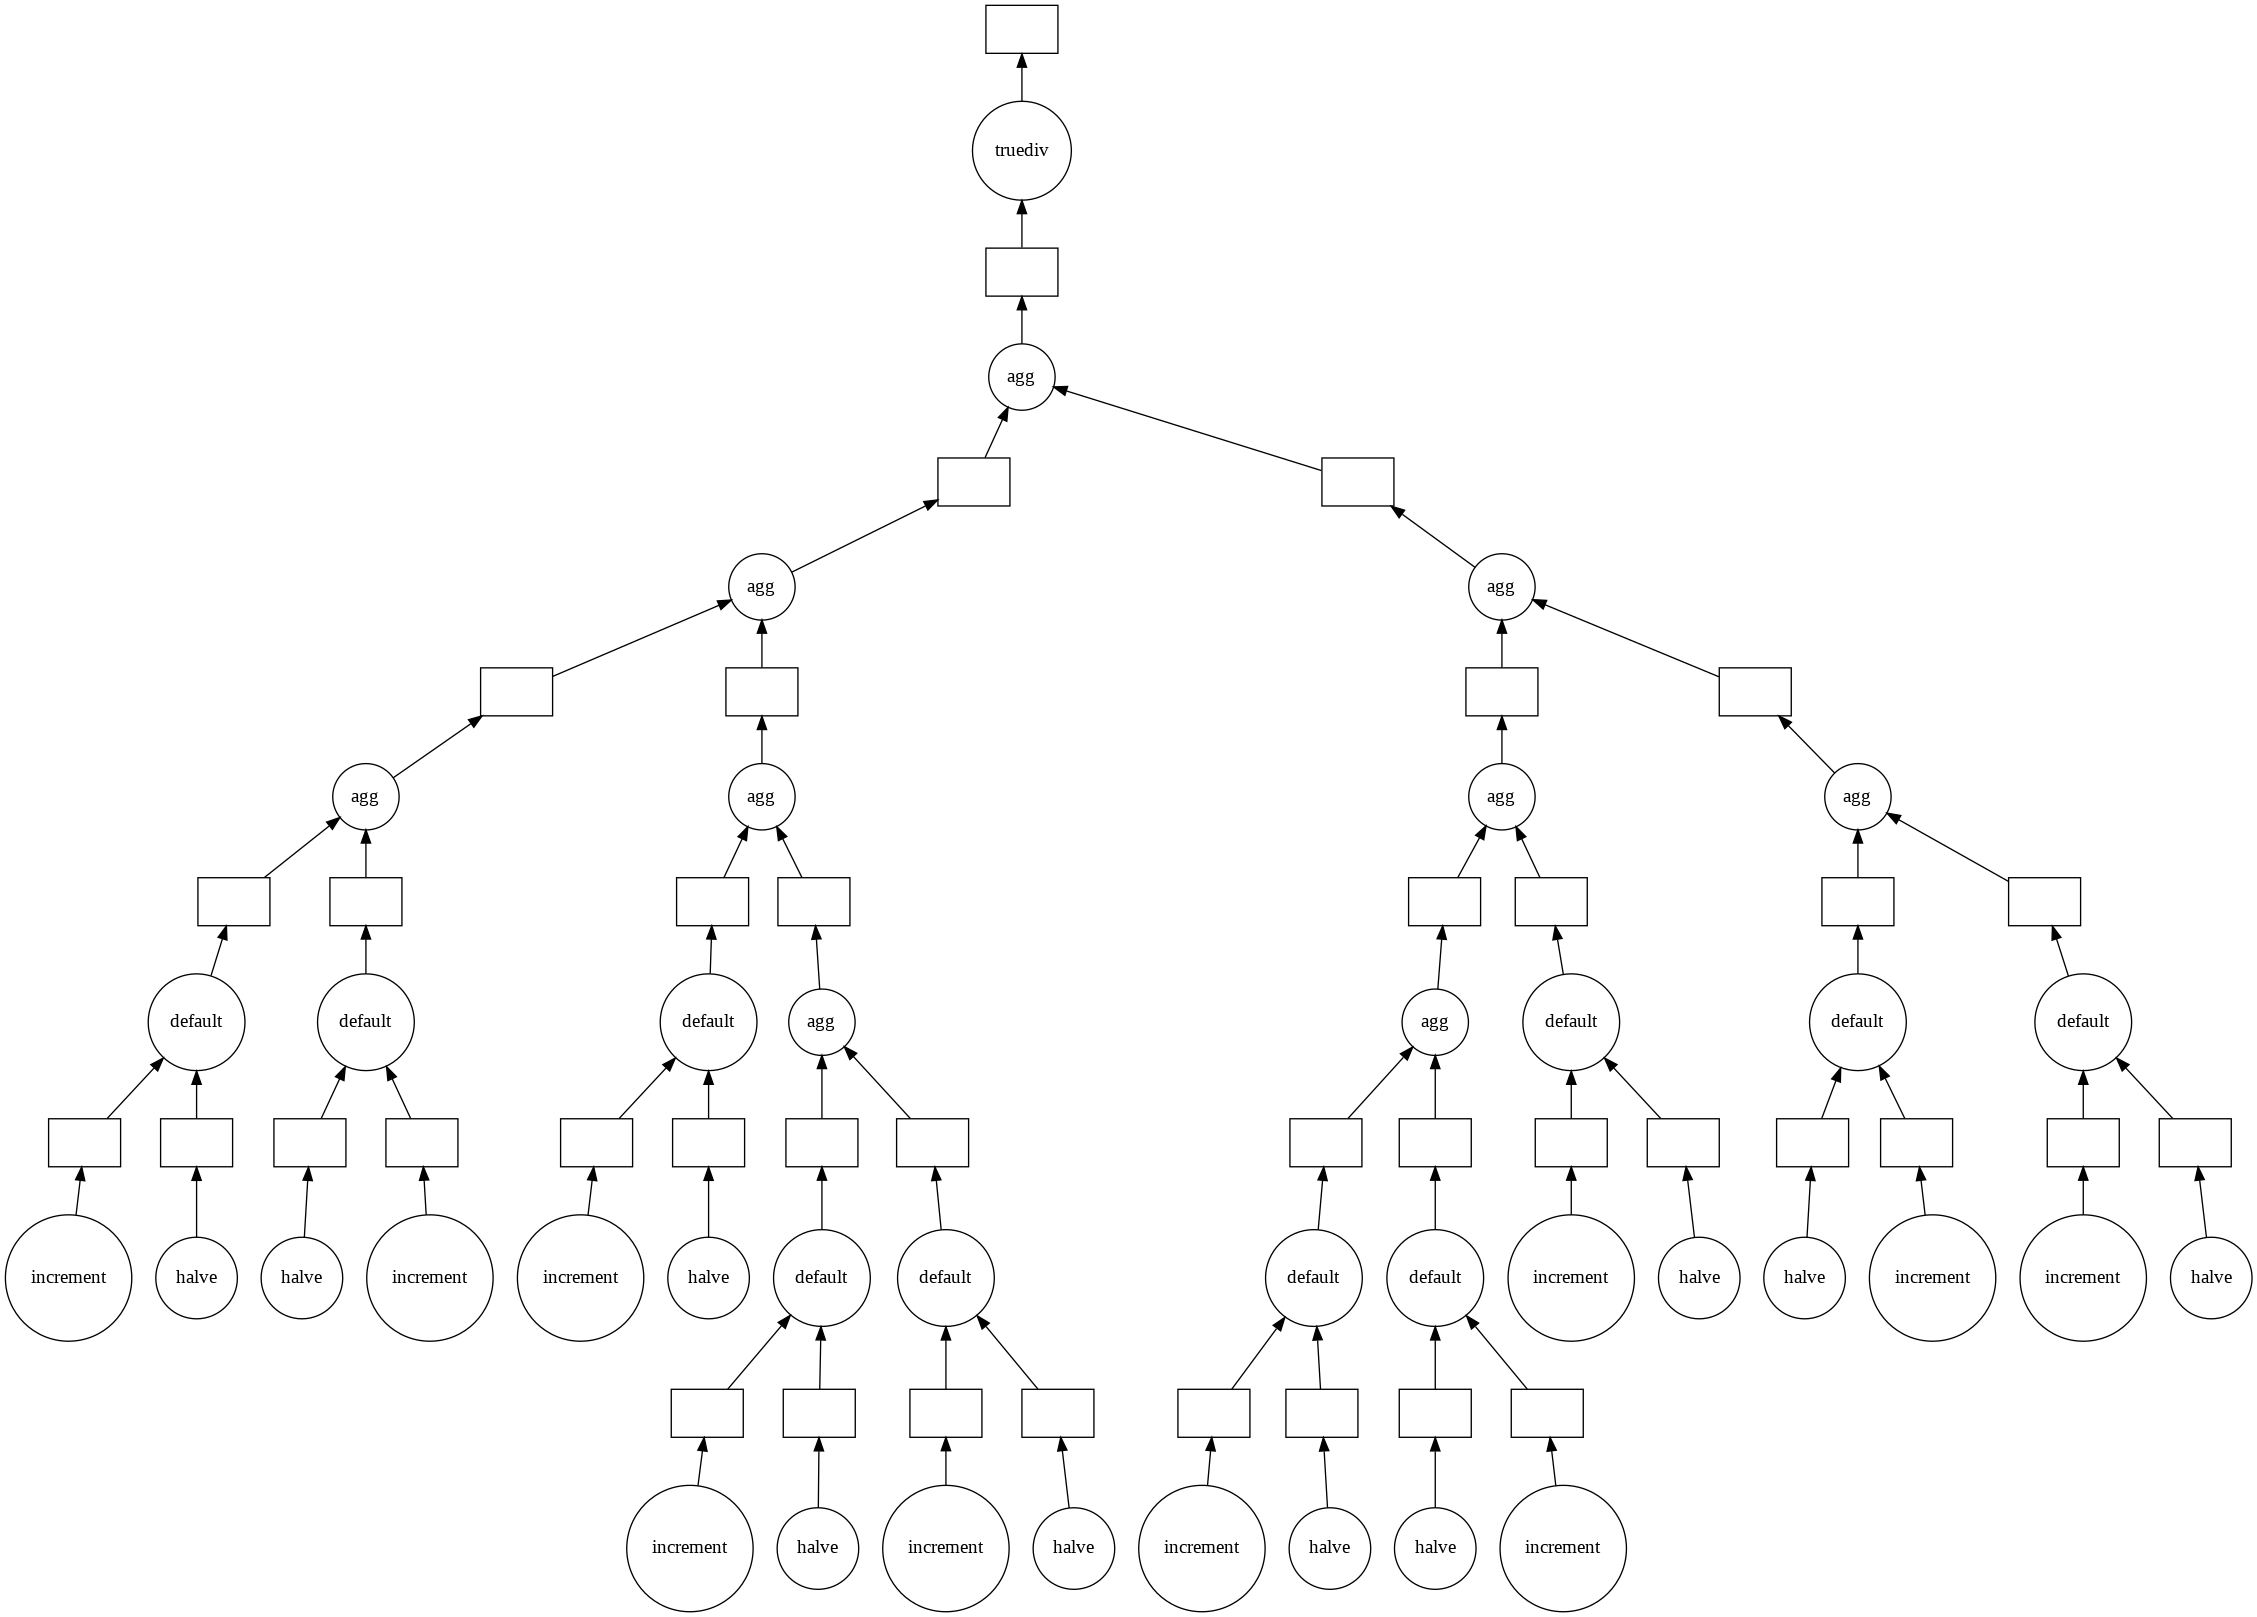

In [ ]:
avg_default.visualize()

In [2]:
%run prep.py -d flights

ERROR:root:File `'prep.py'` not found.


In [3]:
import os
import dask
filename = os.path.join('data', 'accounts.*.csv')
filename


'data/accounts.*.csv'

In [28]:
import pandas as pd
df = pd.read_csv(os.path.join('/content/nycflights.tar.gz'))
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,9,10,11,12,13,14,15,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,nycflights/,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990.0,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990.0,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990.0,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990.0,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990.0,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [7]:
# ¿Cuál es el esquema de la tabla?
df.dtypes

nycflights/          float64
Month                 object
DayofMonth            object
DayOfWeek             object
DepTime               object
CRSDepTime            object
ArrTime               object
CRSArrTime            object
UniqueCarrier         object
FlightNum             object
TailNum               object
ActualElapsedTime     object
CRSElapsedTime        object
AirTime               object
ArrDelay              object
DepDelay              object
Origin                object
Dest                  object
Distance              object
TaxiIn                object
TaxiOut               object
Cancelled             object
Diverted              object
dtype: object

In [14]:
# ¿A cuáles aeropuertos pertenecen los datos?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK', 'Origin', nan], dtype=object)

In [24]:
from dask import compute